In [4]:
#### COMMENT OUT IF NOT USING GOOGLE COLAB ####
from google.colab import drive
drive.mount('/content/drive')

# Set the path to project folder
project_folder = '/content/drive/MyDrive/AAI-511-Final-Project'

# Change the working directory to project folder
os.chdir(project_folder)

# Check the current working directory
print(os.getcwd())

# Install packages that are not on Google Colab
!pip install keras_tuner
!pip install pretty_midi

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1G6OF4L9ScwOcw7r0vT-eDhzl9H2FGva6/AAI-511-Final-Project


In [3]:
# Basic libraries
import os
from PIL import Image

# Statistical libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from imblearn.under_sampling import RandomUnderSampler

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

# MIDI libraries
import pretty_midi
import librosa


<ipython-input-3-4892f54c3079>:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Data Collection
We will be loading files in 2 ways:
- for piano rolls generation
- labeled with features extracted:
  - `avg_pitch`
  - `std_pitch`
  - `avg_duration`
  - `std_duration`
  - `avg_velocity`
  - `std_velocity`
  - `note_vector` -  the sequence of note pitches per midi file
  - `duration_vector`  -  the sequence of note durations per midi file
  - `velocity_vector` - the sequence of note velocities per midi file

In [5]:
# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

composer_dirs = [bach_dir, beethoven_dir, chopin_dir, mozart_dir]

# Long Short-Term Memory

### LSTM - Data Preprocessing (Feature Extraction)

In [7]:
def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Extract note pitches
    pitches = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)

    # Extract note durations
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            durations.append(note.end - note.start)

    # Extract note velocities
    velocities = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            velocities.append(note.velocity)

    # Compute average and standard deviation for features
    features = {
        'avg_pitch': np.mean(pitches),
        'std_pitch': np.std(pitches),
        'avg_duration': np.mean(durations),
        'std_duration': np.std(durations),
        'avg_velocity': np.mean(velocities),
        'std_velocity': np.std(velocities),
        'note_vector': pitches,  # Add the sequence of note pitches as a feature
        'duration_vector': durations,  # Add the sequence of note durations as a feature
        'velocity_vector': velocities  # Add the sequence of note velocities as a feature
    }

    return features


def load_data(directory, current_label, data, success_files, exception_files):
    print(f'Loading {directory} for {current_label}...')
       # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                print(f'Processing {file}...')
                print(f'File path: {file_path}')
                try:
                    features = extract_features(file_path)
                    features['composer'] = current_label
                    data.append(features)
                    success_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    exception_files.append(file_path)

def create_dataframe(data, max_sequence_length = 100):
    df = pd.DataFrame(data)

    df['composer'] = df['composer'].map({0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'})
    df = pd.DataFrame(data)

    # Pad sequences to a fixed length
    note_vectors = pad_sequences(df['note_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    duration_vectors = pad_sequences(df['duration_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    velocity_vectors = pad_sequences(df['velocity_vector'].tolist(), maxlen=max_sequence_length, padding='post')

    # Add padded sequences to the dataframe
    df['note_vector'] = list(note_vectors)
    df['duration_vector'] = list(duration_vectors)
    df['velocity_vector'] = list(velocity_vectors)
    return df

data = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, success_files, exception_files)

# Create dataframe
df = create_dataframe(data)

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Processing Bwv802 Four Inventions (Duettos) Clavier-U"bung III n1.mid...
File path: music_data/midiclassics/Bach/Bwv802 Four Inventions (Duettos) Clavier-U"bung III n1.mid
Processing Bwv0539 Prelude and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0539 Prelude and Fugue.mid
Processing Tocatto No.1 in F Sharp Minor, BWV 910.mid...
File path: music_data/midiclassics/Bach/Tocatto No.1 in F Sharp Minor, BWV 910.mid


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Bwv0540 Toccata and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0540 Toccata and Fugue.mid
Processing Bwv0560 Short Prelude and Fugue n8 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0560 Short Prelude and Fugue n8 (Spurious).mid
Processing Bwv1005 Violin Sonata n3 4mov Allegro.mid...
File path: music_data/midiclassics/Bach/Bwv1005 Violin Sonata n3 4mov Allegro.mid
Processing Bwv0811 English Suite n6 8mov.mid...
File path: music_data/midiclassics/Bach/Bwv0811 English Suite n6 8mov.mid
Processing Bwv0997 Partita for Lute 5mov.mid...
File path: music_data/midiclassics/Bach/Bwv0997 Partita for Lute 5mov.mid
Processing Piano version of Bachs two part inventions No.5.mid...
File path: music_data/midiclassics/Bach/Piano version of Bachs two part inventions No.5.mid
Processing Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid...
File path: music_data/midiclassics/Bach/Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid
Processing Bwv0806 English Suite n1 03mov 

,avg_pitch,std_pitch,avg_duration,std_duration,avg_velocity,std_velocity,note_vector,duration_vector,velocity_vector,composer
0,62.646169,10.804662,0.199172,0.162914,110.000000,0.000000,"[40, 42, 44, 45, 47, 48, 50, 52, 57, 59, 60, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[110, 110, 110, 110, 110, 110, 110, 110, 110, ...",0
1,62.699902,9.727079,0.307592,0.426911,126.737947,3.499689,"[55, 53, 55, 52, 54, 55, 54, 55, 50, 52, 53, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[127, 127, 127, 127, 127, 127, 127, 127, 127, ...",0
2,63.555076,9.502694,0.349317,0.333181,100.000000,0.000000,"[59, 71, 59, 59, 59, 59, 59, 71, 59, 59, 47, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0
3,62.065112,10.115176,0.437945,1.317701,93.759540,3.807810,"[50, 53, 52, 55, 52, 53, 48, 52, 50, 53, 50, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
4,62.635664,8.865362,0.456805,0.450230,93.853752,3.886017,"[53, 45, 48, 50, 50, 51, 50, 51, 53, 55, 53, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0


<ipython-input-8-b350c2eacb07>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='composer', palette='viridis')


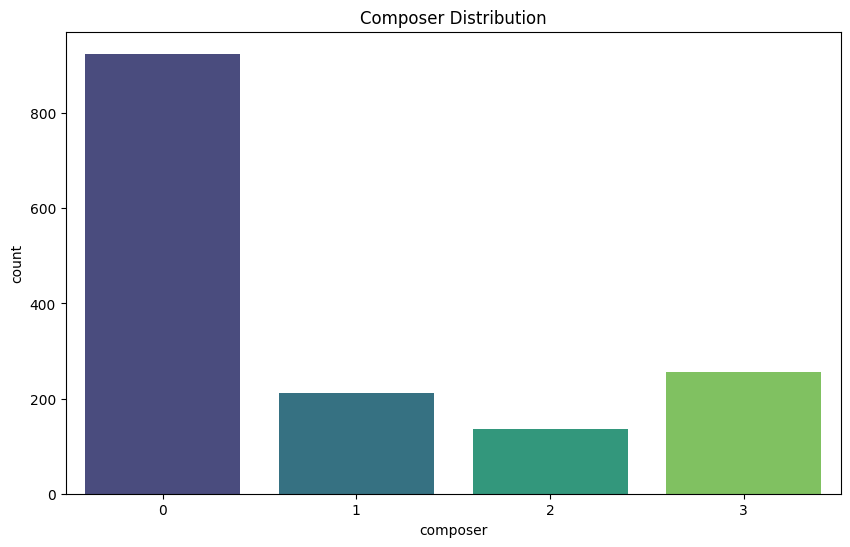

In [8]:
# plot composer distribution, add color for each composer
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer', palette='viridis')
plt.title('Composer Distribution')
plt.show()

<ipython-input-9-b6f2b24b2184>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')


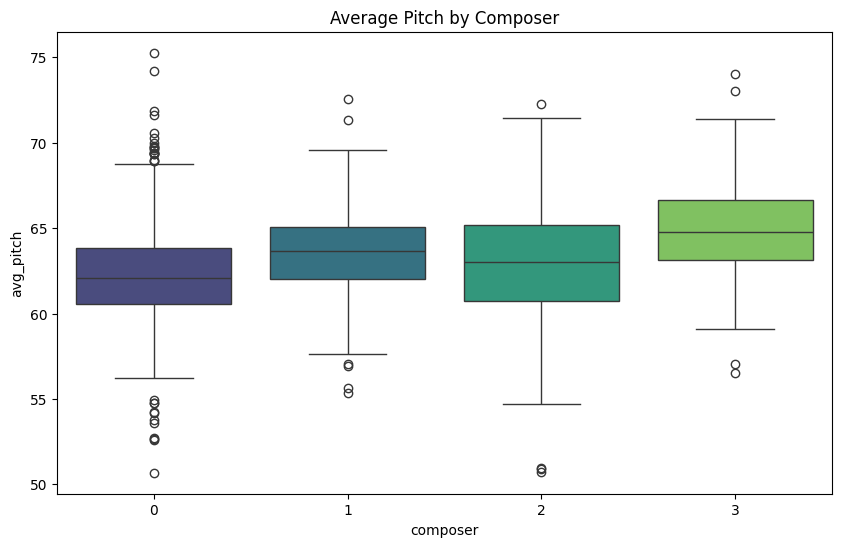

<ipython-input-9-b6f2b24b2184>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')


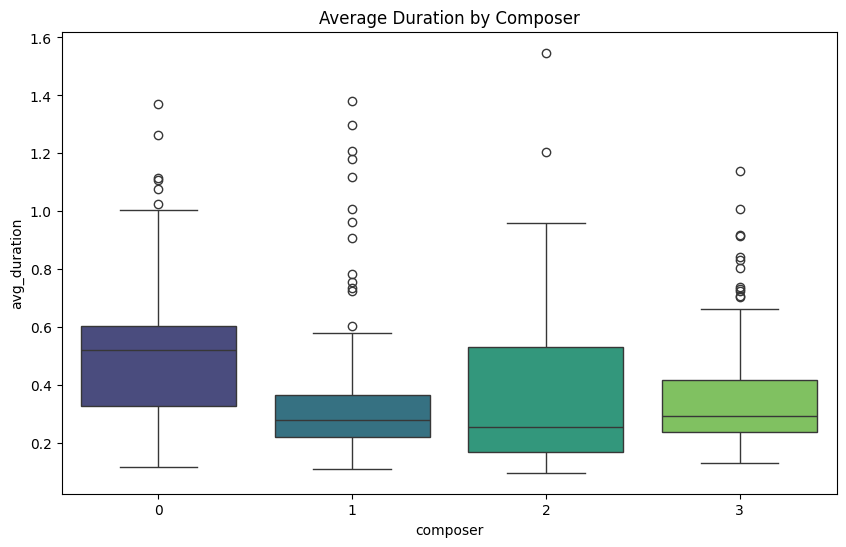

<ipython-input-9-b6f2b24b2184>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')


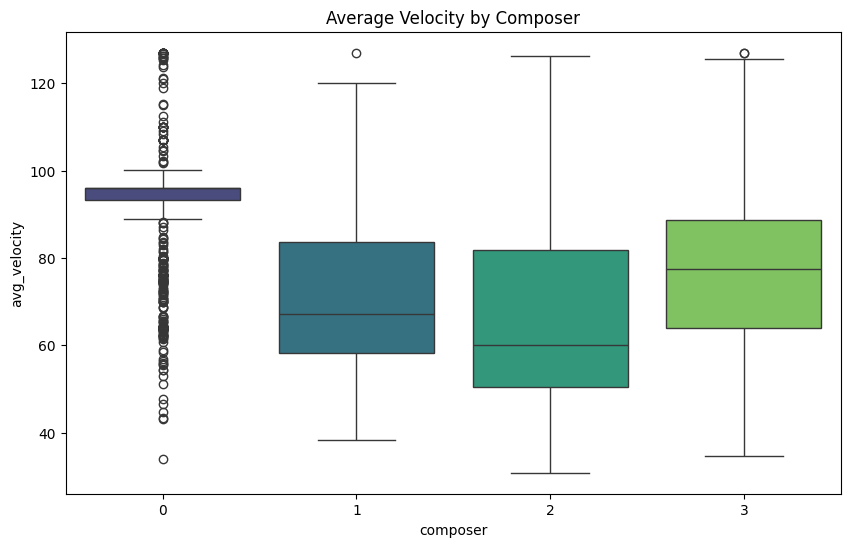

In [9]:
# plot average pitch for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')
plt.title('Average Pitch by Composer')
plt.show()

# plot average duration for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')
plt.title('Average Duration by Composer')
plt.show()

# plot average velocity for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')
plt.title('Average Velocity by Composer')
plt.show()

### LSTM - Data Preprocessing (Address Class Imbalance)

#### Undersampling

In [10]:
# Prepare the dataset
X = df.drop(columns=['composer'])
y = df['composer']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use RandomUnderSampler to handle class imbalance
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_encoded)

# Convert resampled data back to DataFrame for easier handling
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name='composer')

# Verify class distribution after undersampling
print(y_resampled_df.value_counts())

composer
0    136
1    136
2    136
3    136
Name: count, dtype: int64


#### Oversampling

In [11]:
# # For Balancing LSTM files by Copying existing files of sparser folders

# import os
# import shutil
# import random


# # Define the directories and their sizes
# directories = {
#     bach_dir: 925,
#     beethoven_dir: 212,
#     chopin_dir: 136,
#     mozart_dir: 257
# }

# # Find the largest directory size
# max_size = max(directories.values())

# # Function to balance a directory by increasing the number of files
# def balance_directory(directory, target_size):
#     files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
#     current_size = len(files)

#     if current_size < target_size:
#         while current_size < target_size:
#             file_to_duplicate = random.choice(files)
#             base, extension = os.path.splitext(file_to_duplicate)
#             new_file = f"{base}_copy_{current_size}{extension}"
#             try:
#                 shutil.copy(os.path.join(directory, file_to_duplicate), os.path.join(directory, new_file))
#                 files.append(new_file)
#                 current_size += 1
#             except PermissionError as e:
#                 print(f"PermissionError: {e}. Skipping {file_to_duplicate}")

# # Balance each directory
# for dir_name in directories:
#     balance_directory(dir_name, max_size)

### LSTM - Data Preprocessing (Train/Val/Test split)

In [12]:
# Extract and reshape the sequence features for LSTM
note_vectors = np.stack(X_resampled_df['note_vector'].values)
duration_vectors = np.stack(X_resampled_df['duration_vector'].values)
velocity_vectors = np.stack(X_resampled_df['velocity_vector'].values)

# Combine the features into a single 3D array
X_lstm = np.stack((note_vectors, duration_vectors, velocity_vectors), axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_resampled, test_size=0.2, random_state=42)

### LSTM - Model Building

In [13]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### LSTM - Model Training

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2990 - loss: 1.3724 - val_accuracy: 0.4023 - val_loss: 1.2931
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4333 - loss: 1.2679 - val_accuracy: 0.5287 - val_loss: 1.2240
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4771 - loss: 1.2243 - val_accuracy: 0.5287 - val_loss: 1.1655
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4912 - loss: 1.1385 - val_accuracy: 0.5747 - val_loss: 1.1581
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5527 - loss: 1.0508 - val_accuracy: 0.5517 - val_loss: 1.1537
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5016 - loss: 1.1176 - val_accuracy: 0.5632 - val_loss: 1.1520
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5072 - loss: 1.0780 - val_accuracy: 0.4943 - val_loss: 1.1936
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5424 - loss: 1.0615 - val_accuracy: 0.4943 - v

### LSTM - Model Evaluation

### LSTM - Model Optimization

# Convolution Neural Networks

### CNN - Data Preprocessing

In [15]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add it to the list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

# Print the number of MIDI files for each composer
print(f'Bach MIDI files: {len(bach_midi_files)}')
print(f'Beethoven MIDI files: {len(beethoven_midi_files)}')
print(f'Chopin MIDI files: {len(chopin_midi_files)}')
print(f'Mozart MIDI files: {len(mozart_midi_files)}')

Bach MIDI files: 925
Beethoven MIDI files: 212
Chopin MIDI files: 136
Mozart MIDI files: 257


### CNN - Data Preprocessing (Address Class Imbalance)

In [16]:
# Randomly sample 136 MIDI files from each composer
np.random.seed(0)
bach_sample = np.random.choice(bach_midi_files, 136, replace=False)
beethoven_sample = np.random.choice(beethoven_midi_files, 136, replace=False)
chopin_sample = np.random.choice(chopin_midi_files, 136, replace=False)
mozart_sample = np.random.choice(mozart_midi_files, 136, replace=False)

### CNN - Data Preprocessing (Feature Extraction)

In [17]:
def save_piano_roll_png(midi_files, subfolder=''):
    """
    This function iterates over each MIDI file in the array of MIDI
    files passed in, converts the MIDI file into a PrettyMIDI object,
    plots the piano roll by using Librosa's specshow function, and then
    saves the image in the composer's folder.

    Args:
        midi_files (numpy array): List of midi files
        subfolder (string): Name of folder by composer
    """
    # Iterate over each MIDI file
    for midi_file_path in midi_files:
        try:
            # Convert the MIDI file to a PrettyMIDI object
            pm = pretty_midi.PrettyMIDI(midi_file_path)

            # Use librosa's specshow function for displaying the piano roll
            start_pitch = 21
            end_pitch = 108
            librosa.display.specshow(pm.get_piano_roll(50)[start_pitch:end_pitch],
                             hop_length=1, sr=50, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

            # Save the figure to a PNG file
            image_path = f'piano_roll_images/{subfolder}/{os.path.basename(midi_file_path)}.png'
            plt.savefig(image_path)

        except Exception as e:
            print(f"Skipping file {midi_file_path} due to error: {e}")
            continue


In [18]:
#### CODE BLOCKS COMMENTED OUT SINCE IMAGE FILES HAVE ALREADY BEEN CREATED ####
#### FOLDER OF IMAGES CAN BE FOUND ON GITHUB TITLED 'PIANO_ROLLS_IMAGES ####

## Execute function to create and save piano rolls for composers' Midi files

# save_piano_roll_png(bach_sample, subfolder='Bach')

In [19]:
# save_piano_roll_png(beethoven_sample, subfolder='Beethoven')

In [20]:
# save_piano_roll_png(chopin_sample, subfolder='Chopin')

In [21]:
# save_piano_roll_png(mozart_sample, subfolder='Mozart')

In [22]:
def create_df(directory, composer):
    """
    This function creates a pandas DataFrame containing the names of
    all files in a specified directory and associates each file with
    a specified composer.

    Args:
    directory (str): The path to the directory containing the files.
    composer (str): The name of the composer to associate with each file.

    Returns:
    df (pandas.DataFrame): A DataFrame where each row represents a file. The DataFrame has two columns: 'image_id', which contains the file names, and 'composer', which contains the composer associated with each file.
    """
    # Get a list of all file names in the directory
    file_names = [f for f in os.listdir(directory) if f.endswith('.png')]

    # Create a list with the composer name repeated for each image
    labels = [composer] * len(file_names)

    # Create a DataFrame with the image ids and composers
    df = pd.DataFrame({
        'image_id': file_names,
        'composer': labels
    })

    return df

In [23]:
# Execute function to create dataframe with all the image IDs for Bach
bach_pr_df = create_df('piano_roll_images/Bach', 'bach')
print(bach_pr_df.head())

                                       image_id composer
0  Bwv1058 Harpsichord Concerto n7 1mov.mid.png     bach
1                  08. Chor Qui Tollis .mid.png     bach
2                              006206b_.mid.png     bach
3                              006507b_.mid.png     bach
4                              065200b_.mid.png     bach


In [24]:
# Execute function to create dataframe with all the image IDs for Beethoven
beethoven_pr_df = create_df('piano_roll_images/Beethoven', 'beethoven')
print(beethoven_pr_df.head())

                                            image_id   composer
0                     Piano sonata n32 op111.mid.png  beethoven
1  Piano Sonata n08 op13 1mov ''Pathetique''.mid.png  beethoven
2  Piano Sonata n23 op57 2mov ''Apassionata''.mid...  beethoven
3                           Piano Sonata n25.mid.png  beethoven
4                           Piano Sonata n06.mid.png  beethoven


In [25]:
# Execute function to create dataframe with all the image IDs for Bach
chopin_pr_df = create_df('piano_roll_images/Chopin', 'chopin')
print(chopin_pr_df.head())

                                            image_id composer
0  19 Polish Songs, for Solo Voice and Piano acco...   chopin
1                           Nocturne op33 n4.mid.png   chopin
2  Prelude n03 op28 ''Thou Art So Like A Flower''...   chopin
3                           Nocturne op55 n1.mid.png   chopin
4                  Prelude op.28-15 Raindrop.mid.png   chopin


In [26]:
# Execute function to create dataframe with all the image IDs for Bach
mozart_pr_df = create_df('piano_roll_images/Mozart', 'mozart')
print(mozart_pr_df.head())

                                            image_id composer
0  Piano Concerto n26 K537 2mov ''Coronation''.mi...   mozart
1  Piano Concerto n7 for 3 Pianos K242 1mov ''Lod...   mozart
2                 Early Pieces n17 Siciliano.mid.png   mozart
3              Early Pieces n7 Country dance.mid.png   mozart
4               Piano Concerto n14 K449 2mov.mid.png   mozart


In [27]:
# Concatenate each composer's dataframe and reset the index
pianorolls_df = pd.concat([bach_pr_df, beethoven_pr_df, chopin_pr_df, mozart_pr_df])
pianorolls_df = pianorolls_df.reset_index(drop=True)

print(pianorolls_df.head())
print(pianorolls_df.tail())

                                       image_id composer
0  Bwv1058 Harpsichord Concerto n7 1mov.mid.png     bach
1                  08. Chor Qui Tollis .mid.png     bach
2                              006206b_.mid.png     bach
3                              006507b_.mid.png     bach
4                              065200b_.mid.png     bach
                                 image_id composer
538  Piano Concerto n20 K466 3mov.mid.png   mozart
539             Sonatina n21 3mov.mid.png   mozart
540  Piano Concerto n23 K488 1mov.mid.png   mozart
541         Piano Sonata n12 K332.mid.png   mozart
542         Piano Sonata n10 K330.mid.png   mozart


### CNN - Data Preprocessing

In [28]:
# Initialize empty lists to store the piano roll images and labels
pianorolls = []
composers = []

# Iterate over each row in the dataframe
for index, row in pianorolls_df.iterrows():

    # Open the image file
    img = Image.open(f"piano_roll_images/all-piano-rolls/{row['image_id']}")

    # Resize the image to 128 x 128 pixels
    img = img.resize((128,128))

    # Normalize the pixel values to be between 0 and 1
    img = np.array(img)/255.0

    # Append to list of piano roll images
    pianorolls.append(img)

    # Append the composer of the image to the composers list
    composers.append(row['composer'])

# Convert the lists to numpy arrays
pianorolls = np.array(pianorolls)
composers = np.array(composers)




In [29]:
# Use one-hot encoding to convert string labels to integers
encoder = LabelEncoder()
encoder.fit(composers)
one_hot_composer = encoder.transform(composers)

# Convert the composers to binary class matrices
labels = to_categorical(one_hot_composer)

In [30]:
# Print shapes
print(pianorolls.shape)
print(labels.shape)

(543, 128, 128, 4)
(543, 4)


### CNN - Data Preprocessing (Train/Val/Test Split)

In [31]:
# Split the dataset into training, validation, and test set
# 80% training, 10% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(pianorolls,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=15)

### CNN - Model Building

In [32]:
# Build initial model architecture
cnn_model = Sequential([
    # Input layer
    Conv2D(32, (3,3), padding='same',
           activation='relu', input_shape=(128,128,4)),

    #Convolutional layers
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),

    Conv2D(128, (5,5), padding='same', activation='relu'),
    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),

    #Fully-Connected Layer
    Flatten(), #Transform 3D feature map to 1D input tensor
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax') #4 units and softmax chosen for 4 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,758,660 (44.86 MB)

 Trainable params: 11,758,660 (44.86 MB)

 Non-trainable params: 0 (0.00 B)

### CNN - Model Training

In [34]:
# Compile the model
# Categorical cross entropy chosen because each input sample
# belongs to exactly one class and labels are one-hot encoded.
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# Train the initial model on validation set
cnn_model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 926ms/step - accuracy: 0.2195 - loss: 1.9124 - val_accuracy: 0.2037 - val_loss: 1.3863
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 1.3868 - val_accuracy: 0.2593 - val_loss: 1.3862
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2754 - loss: 1.3862 - val_accuracy: 0.2037 - val_loss: 1.3868
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2306 - loss: 1.3864 - val_accuracy: 0.2037 - val_loss: 1.3873
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2354 - loss: 1.3860 - val_accuracy: 0.2037 - val_loss: 1.3879
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2686 - loss: 1.3859 - val_accuracy: 0.2037 - val_loss: 1.3885
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3135 - loss: 1.3851 - val_accuracy: 0.2037 - val_loss: 1.3889
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2686 - loss: 1.3858 - val_accuracy: 0.2037 -

In [36]:
# Define model used to evaluate model
def evaluate_model(model, x, y):
    loss, accuracy = model.evaluate(x, y)

    # Use model to make predictions
    y_pred = model.predict(x)

    # Compute roc auc score before converting to 1D array in next step
    roc_auc = roc_auc_score(y, y_pred, multi_class='ovr')

    # Convert the predictions' probabilities to the class labels
    y_pred = np.argmax(y_pred, axis=1)

    # Convert one-hot-encoded labels to integer labels
    y_true = np.argmax(y, axis=1)

    # Compute f1, precision, and recall scores
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.3f}')
    print(f'Loss: {loss:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC AUC score: {roc_auc:.3f}')

    return y_pred, y_true, accuracy, loss, recall, precision, f1, roc_auc


In [37]:
# Evaluate initial model
y_pred_1, y_true_1, accuracy_1, loss_1, recall_1, precision_1, f1_1, roc_auc_1 = evaluate_model(cnn_model, x_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1983 - loss: 1.3932
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
Accuracy: 0.204
Loss: 1.393
Recall: 0.250
Precision: 0.051
F1 score: 0.085
ROC AUC score: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNN - Model Optimization

In [38]:
# This function builds a model given a set of hyperparameters.
def build_model(hp):
    """
    Builds a convolutional neural network model with hyperparameters.

    The function creates a Sequential model and adds layers to it based on the
    hyperparameters provided. The hyperparameters include the number of filters
    and kernel size for Conv2D layers, the number of units for Dense layers,
    the dropout rate, and the learning rate for the Adam optimizer.

    Parameters:
    hp : HyperParameters
        An instance of Keras Tuner HyperParameters. This object allows you to
        define a hyperparameter search space in a user-friendly way.

    Returns:
    model : Sequential
        The built Keras model. The model is compiled but not trained.

    The model structure is as follows:
    - An input Conv2D layer.
    - A variable number of Conv2D layers, each followed by a MaxPooling2D layer
      and a Dropout layer. The number of layers, the number of filters in the
      Conv2D layers, and the dropout rate are all variable.
    - A Flatten layer.
    - Two Dense layers with a variable number of units, separated by a
      Dropout layer.
    - An output Dense layer with 4 units (one for each class) and a softmax
      activation function for multi-class classfication.

    The model is compiled with the Adam optimizer (with a variable learning
    rate), categorical_crossentropy loss function, and accuracy as the metric.
    """

    model = Sequential()

    #  Input layer with a variable number of filters and kernel size.
    model.add(Conv2D(
        filters=hp.Choice('input_filter',
                          values = [32, 64, 128, 256, 512, 1024, 2048]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(128,128,4)
    ))

    current_size = 128  # initial size of the feature maps
    limit_size = 4  # minimum size of the feature maps

    # Add a variable number of Convolutional layers, each with a variable number
    # of filters and kernel size.
    for i in range(hp.Int('num_layers', 2, 8)):  # choice of 2 to 8 layers

        if current_size >= limit_size: # checks that minimum size is not met
            current_size = current_size // 2  # size after pooling

            # Adds convolutional, maxpooling, and dropout layer
            model.add(Conv2D(
                filters=hp.Choice(f'conv_{i+2}_filter',
                                  values = [32, 64, 128, 256, 512, 1024, 2048]),
                kernel_size=hp.Choice(f'conv_{i+2}_kernel', values = [2,5]),
                activation='relu',
                padding='same'
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(rate=hp.Float(f'dropout_{i+2}',
                                            min_value=0.0,
                                            max_value=0.5,
                                            step=0.1)))
        else:
            break  # stop adding layers when the size is reduced to the limit

    # Flatten the output from the Conv2D layers to feed to fully connected layer
    model.add(Flatten())

    # Fully connected layers of Dense and Dropout layers
    model.add(Dense(
        units=hp.Choice('dense_1_units',
                        values = [32, 64, 128, 256, 512, 1024, 2048]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_final', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Choice('dense_2_units',
                        values = [32, 64, 128, 256, 512, 1024, 2048]),
        activation='relu'
    ))

    # Last layer has 4 units and softmax for 4-class classification
    model.add(Dense(4, activation='softmax'))

    # Compile the model using the Adam optimizer with a variable learning rate,
    # categorical_crossentropy as the loss function, and accuracy as the metric.
    model.compile(optimizer=Adam(hp.Choice('learning_rate',
                                           values=[0.01, 0.001, 0.0001])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [39]:
#### CODE BLOCK COMMENTED OUT TO PREVENT RUNNING TUNING ####

# # Create RandomSearch tuner which tries a random combination of hyperparameters.
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     directory='output',
#     project_name="CNN_Tuning"
# )

# # Print a summary of the search space
# tuner.search_space_summary()

# # Perform the hyperparameter search on validation set
# tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print a dictionary of the best hyperparameters
# best_hyperparameters = best_hps.values
# print(best_hps.values)

# # Results from all trials
# tuner.results_summary()

In [40]:
# Build the optimal CNN model architecture with trial 3 parameters
cnn_final_model = Sequential([
    # Input layer
    Conv2D(512, (5,5), padding='same',
           activation='relu', input_shape=(128,128,4)),

    #Convolutional layers
    Conv2D(2048, (2,2), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.0),

    Conv2D(1024, (5,5), padding='same', activation='relu'),
    MaxPooling2D(5,5),
    Dropout(0.2),

    Conv2D(2048, (5,5), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Conv2D(1024, (5,5), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.0),

    Conv2D(256, (5,5), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.0),

    #Fully-Connected Layer
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])

# Print a summary of the model's architecture
cnn_final_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 512)       │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 2048)      │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 1024)        │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 2048)        │      52,430,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 6, 6, 1024)          │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 256)           │       6,553,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2048)                │         526,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 169,669,892 (647.24 MB)

 Trainable params: 169,669,892 (647.24 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compile the model with Adam optimizer and learning rate or 0.0001
cnn_final_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


In [42]:
# Train the optimal model
cnn_history = cnn_final_model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20


UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-42-f9b1b869ea9b>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.20 = (f32[32,2048,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,129,129]{3,2,1,0} %pad.4, f32[2048,512,2,2]{3,2,1,0} %transpose.71, f32[2048]{0} %arg5.6), window={size=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_7_1/convolution" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4311744512 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_18836]

### CNN - Model Evaluation

In [ ]:
# Evaluate the optimal model on the validation set
 (y_pred_2, y_true_2, accuracy_2, loss_2,
 recall_2, precision_2, f1_2, roc_auc_2) = evaluate_model(cnn_final_model,
                                                          x_val, y_val)

In [ ]:
# Access the training history directly from the model
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the optimal model the test set
 (y_pred_3, y_true_3, accuracy_3, loss_3,
 recall_3, precision_3, f1_3, roc_auc_3) = evaluate_model(cnn_final_model,
                                                          x_test, y_test)

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true_3, y_pred_3)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Composer')
plt.ylabel('Actual Composer')
plt.show()

In [ ]:
# Name of layers
layers = ['conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10',
          'conv2d_11']

for name in layers:
    print('Layer:', name)

    # Select the layer to visualize
    layer_name = name

    # Creates a new model that has the same input as your original model
    # but outputs the activations of the selected layer.
    layer_model = Model(inputs=cnn_final_model.layers[0].input,
                                 outputs=cnn_final_model.get_layer(layer_name).output)

    # Use the new model to make predictions on test data.
    # This gives the activations of the selected layer.
    activation_output = layer_model.predict(x_test)

    # Visualize the output of the first image in `x_test/`
    first_image_output = activation_output[0]

    # Name dimensions of the output shape.
    height, width, num_filters = first_image_output.shape

    # Arrange the images in a grid.
    grid_height = int(num_filters**0.5)
    grid_width = num_filters // grid_height

    # Create a figure with a subplot for each image.
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))

    for i in range(grid_height):
        for j in range(grid_width):
            # Extract the image for this filter
            filter_img = first_image_output[:, :, i*grid_width + j]
            # Display the image in the corresponding subplot
            axs[i, j].imshow(filter_img, cmap='viridis')
            # Hide the axes
            axs[i, j].axis('off')

    # Display the figure
    plt.show()